In [2]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [21]:
runname = "default"
@inline function makestreamfuncvid(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    qRifilename = "qRi.jld2"
    filename = "down_front_mean.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=3)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end

    file = jldopen("$foldername/$filename")
    #qRifile = jldopen("$foldername/$qRifilename")

    n = Observable(101)

    frame = @lift frames[$n]


    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    v = @lift file["timeseries/v_dfm/$($frame)"][:, 1, :]

    u = @lift file["timeseries/u_dfm/$($frame)"][:, 1, :]
    w = @lift file["timeseries/w_dfm/$($frame)"][:, 1, :]

    b = @lift file["timeseries/b_dfm/$($frame)"][:, 1, :]
    σ=3
    # Get the secondary cirulation streamfunction
    ψ = @lift imfilter(ψᶜᶜᶜ($u, $w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ), gaussian((σ, 0), (4σ+1, 5)), "circular")
    # Vorticity
    
    ζ = @lift imfilter((circshift($v, (-1, 0)) .- circshift($v, (1, 0))) / (xᶜᵃᵃ[3] - xᶜᵃᵃ[1]), gaussian((σ, 0), (4σ+1, 5)), "circular")
    #ζ_check = @lift ifelse
    #q = @lift imfilter(qRifile["timeseries/q/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 5)), "circular")
    #invRi = @lift imfilter(qRifile["timeseries/invRi/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 5)), "circular")
    title = @lift "$runname, t = $(round(ts[$n]; digits=2))"

    axis_kwargs = (; xlabel="x", ylabel="z", title, limits=(-2, 0, -0.12, 0))

    fig = Figure(resolution=(900, 600))
    ax = Axis(fig[1, 1]; axis_kwargs...)

    ht = heatmap!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ζ; colormap=:balance, colorrange=(-6, 6))
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ψ; colormap=:BrBG_10, levels=range(-0.012, 0.012, 160), alpha=1, linewidth=1.5)
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 1), levels=range(-200, 200, 160), linewidth=1.5)
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ζ; color=(:red, 1), levels=[-1], linewidth=1.5)
    #contour!(ax, xᶜᵃᵃ, zᵃᵃᶠ, invRi; color=:blue, levels=[1/0.95, 1/0.25])
    #contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, q; color=:red, levels=[0])
    Colorbar(fig[1, 2], ht, label=L"\langle ζ \rangle")
    
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/streamfunctiontop"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(1200, 800))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    #rm("$vidfoldername.zip")
    fig
end

makestreamfuncvid (generic function with 2 methods)

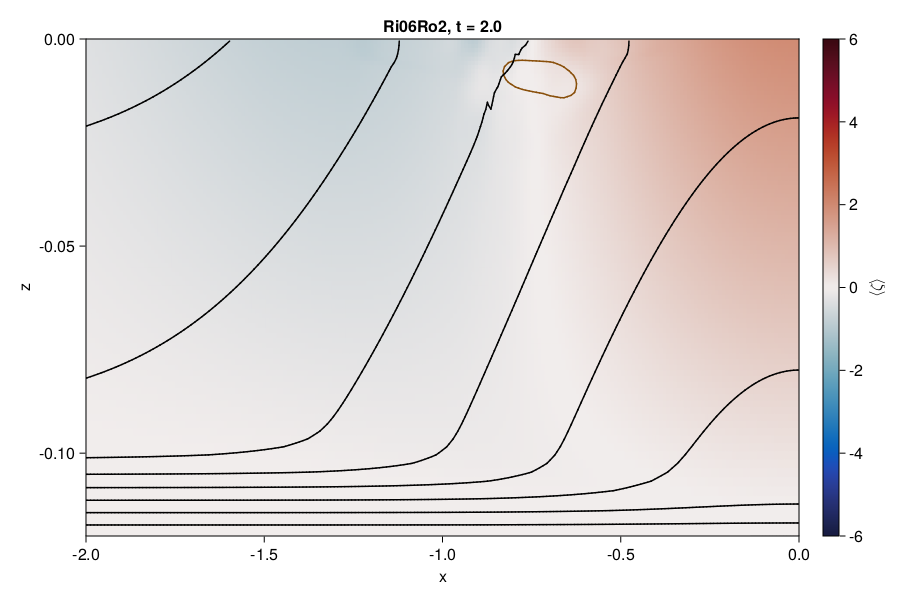

In [52]:
makestreamfuncvid("Ri06Ro2", 501)

In [ ]:
runnames = ["Ri02Ro2", "Ri02Ro3", "Ri06Ro2", "Ri06Ro3", "Ri09Ro2", "Ri09Ro3", "Ri1Ro2", "Ri1Ro3"]
for runname in runnames
    makestreamfuncvid(runname)
end

In [ ]:
# -200 200 and 160